In [7]:
import pyvista as pv
import numpy as np
from typing import Any, Tuple
from importlib import reload
import multiprocessing
import ifcopenshell
import ifcopenshell.geom
import time
from functools import reduce
import open3d as o3d

In [8]:
def open3d_block_by_element(ifc_file): 
    settings = ifcopenshell.geom.settings()
    settings.set(settings.USE_WORLD_COORDS, True)
    settings.set(settings.APPLY_DEFAULT_MATERIALS, True)
    iterator = ifcopenshell.geom.iterator(settings, ifc_file, multiprocessing.cpu_count())
    include_list = ["IfcWall", "IfcSlab", "IfcBeam", "IfcColumn", "IfcWallStandardCase", "IfcFoundation", "IfcRoof"]
    all_meshes = []
    element_information = {}
    ind = 0
    temp_dimension = 5.0
    if iterator.initialize():
        while True:
            shape = iterator.get()
            if shape.type in include_list:
                
                product = ifc_file.by_guid(shape.guid)

                faces = np.array(shape.geometry.faces)             
                verts = np.array(shape.geometry.verts).reshape(-1, 3)
                mesh = o3d.geometry.TriangleMesh()
                mesh.vertices = o3d.utility.Vector3dVector(verts)
                mesh.triangles = o3d.utility.Vector3iVector(faces.reshape(-1, 3))

                #find the smallest dimension of the mesh
                min_dimension = min(mesh.get_max_bound() - mesh.get_min_bound())
                if min_dimension > 0.1:
                    if temp_dimension > min_dimension:
                        temp_dimension = round(float(min_dimension),3)
                
                all_meshes.append(mesh)
         
                #attributes = product.get_info()
                element_information[ind] = shape.guid
                ind += 1
                        
            if not iterator.next():
                break
    

    return all_meshes, element_information, temp_dimension

def create_uniform_grid(bounds, voxel_size):
    """Create a uniform grid within the given bounds."""
    x = np.arange(bounds[0], bounds[1] + voxel_size, voxel_size)
    y = np.arange(bounds[2], bounds[3] + voxel_size, voxel_size)
    z = np.arange(bounds[4], bounds[5] + voxel_size, voxel_size)
    return pv.StructuredGrid(*np.meshgrid(x, y, z))

def open3d_to_pyvista(point_cloud_o3d):
    """
    Convert an Open3D point cloud to a PyVista point cloud.

    Parameters:
    - point_cloud_o3d: The Open3D point cloud.

    Returns:
    - A PyVista `PolyData` object.
    """
    # Extract points from Open3D point cloud
    points = np.asarray(point_cloud_o3d.points)

    # Create a PyVista PolyData object
    point_cloud_pv = pv.PolyData(points)

    return point_cloud_pv

def aabb_intersection(aabb1_min, aabb1_max, aabb2_min, aabb2_max):
    return (aabb1_min[0] <= aabb2_max[0] and aabb1_max[0] >= aabb2_min[0] and
            aabb1_min[1] <= aabb2_max[1] and aabb1_max[1] >= aabb2_min[1] and
            aabb1_min[2] <= aabb2_max[2] and aabb1_max[2] >= aabb2_min[2])

def voxelize_space_with_octree(bounds, element_information, octree, voxel_size):
    
    """Create a 3d grid and check the intersections of the meshes with the grid using octree."""
    grid = create_uniform_grid(bounds, voxel_size)
    empty_grid = create_uniform_grid(bounds, voxel_size)
    
    dims = grid.dimensions
    grid_values = np.zeros((dims[0]-1, dims[1]-1, dims[2]-1))
    grid_attributes = np.empty((dims[0]-1, dims[1]-1, dims[2]-1), dtype=object)

    grid_bounds = grid.bounds
    
    def traverse_octree(node, voxel_min, voxel_max):
        if isinstance(node, o3d.geometry.OctreeLeafNode):
            # Check if this leaf node's bounding box intersects with the voxel
            if aabb_intersection(node.bounding_box_min, node.bounding_box_max, voxel_min, voxel_max):
                return True
        elif isinstance(node, o3d.geometry.OctreeInternalNode):
            # Check if this internal node's bounding box intersects with the voxel
            if aabb_intersection(node.bounding_box_min, node.bounding_box_max, voxel_min, voxel_max):
                for child in node.children:
                    if child and traverse_octree(child, voxel_min, voxel_max):
                        return True
        return False

    def octree_traversal_callback(node, voxel_min, voxel_max):
        return traverse_octree(node, voxel_min, voxel_max)

    for i in range(dims[0]-1):
        for j in range(dims[1]-1):
            for k in range(dims[2]-1):
                voxel_min = [i*voxel_size, j*voxel_size, k*voxel_size]
                voxel_max = [voxel_min[0] + voxel_size, voxel_min[1] + voxel_size, voxel_min[2] + voxel_size]
                
                if octree.traverse(octree_traversal_callback, voxel_min, voxel_max):
                    grid_values[i,j,k] = 1
                    
    grid.cell_data['values'] = grid_values.flatten(order='F').astype(bool)
    grid.cell_data['attributes'] = grid_attributes.flatten(order='F').astype(str)
    
    return grid, empty_grid


def get_sampling_points(mesh, voxel_size, points_per_unit_area=120):
    
    # Calculate the surface area of the mesh
    area = mesh.get_surface_area()

    # Calculate the number of points to sample
    N = int(area * points_per_unit_area*1/voxel_size)
        
    return N

def create_point_cloud(all_meshes, voxel_size):
    """Create a point cloud from a mesh."""

    pcd_list = []
    sampling_pts = 0
    for mesh in all_meshes:
        # Get the number of points to sample based on the mesh size
        N = get_sampling_points(mesh, voxel_size)
        pcd = mesh.sample_points_uniformly(N)
        pcd_pv = open3d_to_pyvista(pcd)
        pcd_list.append(pcd_pv)  
    
    return pcd_list

def f_traverse(node, node_info):
    early_stop = False

    if isinstance(node, o3d.geometry.OctreeInternalNode):
        if isinstance(node, o3d.geometry.OctreeInternalPointNode):
            n = 0
            for child in node.children:
                if child is not None:
                    n += 1
            print(
                "{}{}: Internal node at depth {} has {} children and {} points ({})"
                .format('    ' * node_info.depth,
                        node_info.child_index, node_info.depth, n,
                        len(node.indices), node_info.origin))

            # we only want to process nodes / spatial regions with enough points
            early_stop = len(node.indices) < 250
    elif isinstance(node, o3d.geometry.OctreeLeafNode):
        if isinstance(node, o3d.geometry.OctreePointColorLeafNode):
            print("{}{}: Leaf node at depth {} has {} points with origin {}".
                  format('    ' * node_info.depth, node_info.child_index,
                         node_info.depth, len(node.indices), node_info.origin))
    else:
        raise NotImplementedError('Node type not recognized!')

    # early stopping: if True, traversal of children of the current node will be skipped
    return early_stop

In [9]:
file_name = "05_Cluster.ifc"
ifc_file = ifcopenshell.open(r"IFC Files\05_Cluster.ifc")

### CONVERSION FROM IFC TO MESH ###
start_time = time.time()
all_meshes, element_information, voxel_size = open3d_block_by_element(ifc_file)
end_time = time.time()
conversion_time = end_time - start_time
total_polygons = sum(len(mesh.triangles) for mesh in all_meshes)

# combine all meshes into one mesh and find the bounds
combined_mesh = reduce(lambda m1, m2: m1 + m2, all_meshes)
bbox = combined_mesh.get_axis_aligned_bounding_box()
xmin, ymin, zmin = bbox.get_min_bound()
xmax, ymax, zmax = bbox.get_max_bound()
bounds = np.array([xmin, xmax, ymin, ymax, zmin, zmax])

### POINT CLOUD CREATION ###
start_time = time.time()
point_cloud_list  = create_point_cloud(all_meshes, voxel_size)
pcd = np.vstack(list(map(lambda x: x.points, point_cloud_list)))

pcd_o3d = o3d.geometry.PointCloud()
pcd_o3d.points = o3d.utility.Vector3dVector(pcd)

octree = o3d.geometry.Octree(max_depth=5)
octree.convert_from_point_cloud(pcd_o3d, size_expand=0.01)
octree.traverse(f_traverse)

#merge all the list of point clouds into one
pcd_pv = pv.PolyData()
pcd_pv.points = np.vstack(list(map(lambda x: x.points, point_cloud_list)))

sampling_points = len(pcd_pv.points)
end_time = time.time()
point_cloud_processing = end_time - start_time
print(f'Voxel size: {voxel_size}')
print(f"Time taken to convert objects: {conversion_time:.4f} seconds")
print(f'Total number of points: {sampling_points}')
print(f"Time taken to create point cloud: {point_cloud_processing:.4f} seconds")
print(f"Total number of polygons across all meshes: {total_polygons}")

### RASTERIZATION ###
start_time = time.time()
grid, empty_grid = voxelize_space_with_octree(bounds, element_information, octree, voxel_size)

print(f'Total number of cells: {grid.n_cells}')
end_time = time.time()
rasterization_time = end_time - start_time
print(f"Time taken to rasterize: {rasterization_time:.4f} seconds")


0: Internal node at depth 0 has 8 children and 53810760 points ([2.91565739e+05 5.62987458e+06 1.94134342e+02])
    0: Internal node at depth 1 has 4 children and 6855261 points ([2.91565739e+05 5.62987458e+06 1.94134342e+02])
        4: Internal node at depth 2 has 4 children and 425169 points ([2.91565739e+05 5.62987458e+06 2.10890574e+02])
            2: Internal node at depth 3 has 2 children and 64618 points ([2.91565739e+05 5.62988296e+06 2.10890574e+02])
                6: Internal node at depth 4 has 4 children and 21140 points ([2.91565739e+05 5.62988715e+06 2.15079632e+02])
                    2: Leaf node at depth 5 has 381 points with origin [2.91565739e+05 5.62988924e+06 2.15079632e+02]
                    3: Leaf node at depth 5 has 8193 points with origin [2.91567833e+05 5.62988924e+06 2.15079632e+02]
                    6: Leaf node at depth 5 has 805 points with origin [2.91565739e+05 5.62988924e+06 2.17174161e+02]
                    7: Leaf node at depth 5 has 11761 

TypeError: traverse(): incompatible function arguments. The following argument types are supported:
    1. (self: open3d.cpu.pybind.geometry.Octree, f: Callable[[open3d.cpu.pybind.geometry.OctreeNode, open3d.cpu.pybind.geometry.OctreeNodeInfo], bool]) -> None

Invoked with: Octree with origin: [291566, 5.62987e+06, 194.134], size: 67.0249, max_depth: 5, <function voxelize_space_with_octree.<locals>.octree_traversal_callback at 0x0000020C29551480>, [0.0, 0.0, 0.0], [0.106, 0.106, 0.106]

c:\Users\Laptop\AppData\Local\Programs\Python\Python310\lib\site-packages\pyvista\jupyter\notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


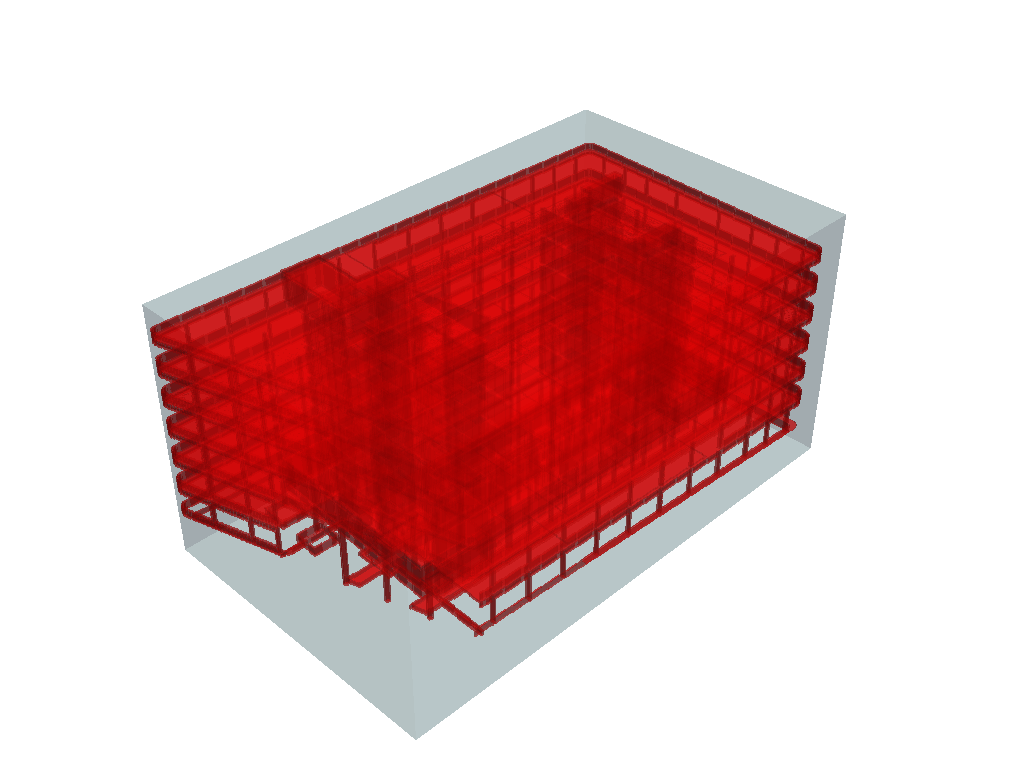

Time taken to visualize: 9.9509 seconds


In [ ]:
### VISUALIZATION ###
start_time = time.time()
p = pv.Plotter()
p.add_mesh(pcd_pv, color="blue", point_size=10.0, render_points_as_spheres=True)
p.add_mesh(empty_grid, opacity=0.3,show_edges=False)
p.add_mesh(grid.extract_cells(grid.cell_data['values']), color="red", opacity=0.6,show_edges=False)
p.show()
end_time = time.time()
visualization_time = end_time - start_time
print(f"Time taken to visualize: {visualization_time:.4f} seconds")

In [ ]:
import pandas as pd

results = {}  # Dictionary to store the results for each IFC file

# Store the results in the dictionary
results['File'] = file_name
results['Conversion Time'] = conversion_time
results['Total Polygons'] = total_polygons
results['Voxel Size'] = voxel_size
results['Total Points'] = sampling_points
results['Point Cloud Creation Time'] = point_cloud_processing
results['Rasterization Time'] = rasterization_time
results['Visualization Time'] = visualization_time
#results['Concrete Volume'] = concrete_volume

df = pd.DataFrame([results])

df.to_excel("performance_results.xlsx", index=False)


In [ ]:
### FETCHING CONCRETE ELEMENTS ###
def fetch_concrete_elements(ifc_file):
    concrete_elements = []
    elements = ifc_file.by_type("IfcBuildingElement")
    for element in elements:
        if "concrete" in element.ObjectType.lower():
            if element.GlobalId not in concrete_elements:
                concrete_elements.append(element.GlobalId)
        if "STB" in element.Name:
            if element.GlobalId not in concrete_elements:
                concrete_elements.append(element.GlobalId)

    return concrete_elements

concrete_elements = fetch_concrete_elements(ifc_file)
total_count = 0

for element in concrete_elements:
     
    matching_cells = np.where(grid.cell_data['attributes'] == element)[0]
    
    # Count the number of matching cells
    total_count += len(matching_cells)
    
concrete_volume = round(total_count*voxel_size*voxel_size*voxel_size,3)
print(f'Total concrete volume is {concrete_volume} m3')

KeyboardInterrupt: 